<a href="https://colab.research.google.com/github/vladislavpan1623/-1-/blob/main/%D0%9B%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%BE%D1%80%D0%BD%D0%B04_1_3b_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.  Завдання щодо генерації текстів або машинного перекладу (на вибір) на базі рекурентних мереж або трансформерів (на вибір).
Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.

Обрано машинний переклад

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import re
import io
import zipfile
import os
from google.colab import files

# 1. Завантаження файлу
print("Крок 1: Завантажте ваш ZIP-архів (ukr-eng.zip)")
uploaded = files.upload()

if not uploaded:
    print("Файл не було обрано.")
else:
    file_name = list(uploaded.keys())[0]

    # 2. Розпакування
    extract_path = 'translation_data'
    with zipfile.ZipFile(io.BytesIO(uploaded[file_name]), 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    txt_file_path = os.path.join(extract_path, 'ukr.txt')

    # 3. Функція для очищення тексту
    def preprocess_sentence(w):
        w = w.lower().strip()
        w = re.sub(r"([?.!,¿])", r" \1 ", w) # Відокремлюємо пунктуацію
        w = re.sub(r'[" "]+', " ", w)
        # Додаємо токени початку та кінця речення
        return f'<sos> {w.strip()} <eos>'

    # 4. Читання та створення пар
    lines = open(txt_file_path, encoding='utf-8').read().strip().split('\n')

    # Беремо перші 15 000 речень для швидкого навчання
    word_pairs = []
    for l in lines[:15000]:
        parts = l.split('\t')
        if len(parts) >= 2:
            en = preprocess_sentence(parts[0])
            uk = preprocess_sentence(parts[1])
            word_pairs.append([en, uk])

    en_sentences, uk_sentences = zip(*word_pairs)
    print(f"Завантажено пар: {len(word_pairs)}")
    print(f"Приклад: {en_sentences[10]} ===> {uk_sentences[10]}")

Крок 1: Завантажте ваш ZIP-архів (ukr-eng.zip)


Saving ukr-eng.zip to ukr-eng.zip
Завантажено пар: 15000
Приклад: <sos> wow ! <eos> ===> <sos> ого ! <eos>


In [ ]:
class LangVocab:
    def __init__(self):
        self.word2index = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.index2word = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.n_words = 4

    def add_sentence(self, sentence):
        for word in sentence.split():
            if word not in self.word2index:
                self.word2index[word] = self.n_words
                self.index2word[self.n_words] = word
                self.n_words += 1

# Створюємо словники для обох мов
input_lang = LangVocab()
output_lang = LangVocab()

for en, uk in word_pairs:
    input_lang.add_sentence(en)
    output_lang.add_sentence(uk)

print(f"Англійський словник: {input_lang.n_words} слів")
print(f"Український словник: {output_lang.n_words} слів")

Англійський словник: 2708 слів
Український словник: 6506 слів


In [ ]:
def tokenize_sentence(vocab, sentence):
    return [vocab.word2index.get(word, 3) for word in sentence.split()]

# Конвертуємо речення в послідовності чисел
input_sequences = [tokenize_sentence(input_lang, s) for s in en_sentences]
target_sequences = [tokenize_sentence(output_lang, s) for s in uk_sentences]

# Знаходимо максимальну довжину
max_len_en = max(len(s) for s in input_sequences)
max_len_uk = max(len(s) for s in target_sequences)
max_len = max(max_len_en, max_len_uk)

# Padding (додаємо нулі в кінець коротких речень)
def pad_seq(seq, max_len):
    return seq + [0] * (max_len - len(seq))

input_tensor = torch.tensor([pad_seq(s, max_len) for s in input_sequences])
target_tensor = torch.tensor([pad_seq(s, max_len) for s in target_sequences])

# Створюємо Dataset та Loader
dataset = TensorDataset(input_tensor, target_tensor)
train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

print(f"Тензори готові. Розмірність: {input_tensor.shape}")

Тензори готові. Розмірність: torch.Size([15000, 12])


In [ ]:
import torch.nn as nn

# 1. Енкодер (Encoder)
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)

    def forward(self, input):
        # input: [batch_size, seq_len]
        embedded = self.embedding(input)
        # embedded: [batch_size, seq_len, emb_dim]
        outputs, hidden = self.gru(embedded)
        # hidden: [1, batch_size, hid_dim]
        return hidden

# 2. Декодер (Decoder)
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        self.output_dim = output_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU(emb_dim, hid_dim, batch_first=True)
        self.fc_out = nn.Linear(hid_dim, output_dim)

    def forward(self, input, hidden):
        # input: [batch_size, 1] (одне слово за раз)
        embedded = self.embedding(input)
        output, hidden = self.gru(embedded, hidden)
        prediction = self.fc_out(output.squeeze(1))
        return prediction, hidden

# 3. Об'єднуюча модель Seq2Seq
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1]
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        hidden = self.encoder(src)

        # Перше слово для декодера - це завжди <sos>
        input = trg[:, 0].unsqueeze(1)

        for t in range(1, trg_len):
            output, hidden = self.decoder(input, hidden)
            outputs[:, t] = output

            # Використовуємо Teacher Forcing (підказка правильного слова)
            top1 = output.argmax(1)
            import random
            input = trg[:, t].unsqueeze(1) if random.random() < teacher_forcing_ratio else top1.unsqueeze(1)

        return outputs

In [ ]:
from torch.cuda.amp import GradScaler, autocast
import torch.optim as optim

# 1. Оптимізація DataLoader (пришвидшуємо подачу даних)
# Збільшуємо Batch Size до 256 для максимального завантаження GPU
train_loader = DataLoader(
    dataset,
    batch_size=256,
    shuffle=True,
    num_workers=2,        # Паралельне завантаження (для Colab оптимально 2)
    pin_memory=True       # Швидка передача даних в GPU
)

# 2. Налаштування пристрою та моделі
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True # Оптимізація алгоритмів згортки/RNN під ваше залізо

# Ініціалізація (якщо модель вже створена, цей крок можна пропустити)
model = Seq2Seq(enc, dec, device).to(device)

# 3. Оптимізатор AdamW та планувальник OneCycleLR
# AdamW краще за звичайний Adam для стабільності на високих швидкостях
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)

# Планувальник, який розганяє навчання (Super-convergence)
epochs = 20
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.005,
    steps_per_epoch=len(train_loader),
    epochs=epochs
)

# Інструмент для Mixed Precision (16-бітні обчислення)
scaler = GradScaler()
criterion = nn.CrossEntropyLoss(ignore_index=0)

print(f"Запуск прискореного навчання на {device}...")

for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for src, trg in train_loader:
        # non_blocking=True дозволяє CPU не чекати GPU
        src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)

        # set_to_none=True швидше, ніж звичайне обнулення
        optimizer.zero_grad(set_to_none=True)

        # Автоматичне використання 16-бітних чисел (Mixed Precision)
        with autocast():
            output = model(src, trg)

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)

        # Швидкий зворотний прохід
        scaler.scale(loss).backward()

        # Кліппінг градієнтів (запобігання помилкам)
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scaler.update()

        # Оновлення швидкості навчання (Learning Rate)
        scheduler.step()

        epoch_loss += loss.item()

    # Виводимо результат раз на епоху (щоб не гальмувати консоль)
    avg_loss = epoch_loss / len(train_loader)
    current_lr = scheduler.get_last_lr()[0]
    print(f"Епоха: {epoch+1:02}/{epochs} | Loss: {avg_loss:.4f} | LR: {current_lr:.5f}")

print("--- Навчання завершено! ---")

Запуск прискореного навчання на cpu...


/tmp/ipython-input-3121500537.py:35: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipython-input-3121500537.py:52: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Епоха: 01/20 | Loss: 2.6139 | LR: 0.00052
Епоха: 02/20 | Loss: 2.4418 | LR: 0.00141
Епоха: 03/20 | Loss: 2.1929 | LR: 0.00261
Епоха: 04/20 | Loss: 1.8833 | LR: 0.00381
Епоха: 05/20 | Loss: 1.5756 | LR: 0.00469
Епоха: 06/20 | Loss: 1.3283 | LR: 0.00500
Епоха: 07/20 | Loss: 1.1849 | LR: 0.00494
Епоха: 08/20 | Loss: 1.0639 | LR: 0.00475
Епоха: 09/20 | Loss: 0.9589 | LR: 0.00445
Епоха: 10/20 | Loss: 0.8795 | LR: 0.00405
Епоха: 11/20 | Loss: 0.8158 | LR: 0.00358
Епоха: 12/20 | Loss: 0.7338 | LR: 0.00305
Епоха: 13/20 | Loss: 0.6536 | LR: 0.00249
Епоха: 14/20 | Loss: 0.6104 | LR: 0.00193
Епоха: 15/20 | Loss: 0.5033 | LR: 0.00141
Епоха: 16/20 | Loss: 0.4354 | LR: 0.00093
Епоха: 17/20 | Loss: 0.3804 | LR: 0.00054
Епоха: 18/20 | Loss: 0.3060 | LR: 0.00024
Епоха: 19/20 | Loss: 0.2608 | LR: 0.00006
Епоха: 20/20 | Loss: 0.2565 | LR: 0.00000
--- Навчання завершено! ---


In [ ]:
# 1. Перевірка та ініціалізація лічильника епох (якщо він ще не існує)
if 'current_epoch' not in locals():
    current_epoch = 20  # Вкажіть тут кількість епох, яку ви вже пройшли в Етапі 5
    print(f"Лічильник ініціалізовано: починаємо після {current_epoch} епох.")

# 2. Вкажіть, скільки епох ви хочете ДОДАТИ зараз
additional_epochs = 10
target_epoch = current_epoch + additional_epochs

# 3. Створюємо новий планувальник для цього "забігу"
scheduler_extra = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=0.001,
    steps_per_epoch=len(train_loader),
    epochs=additional_epochs
)

print(f"Продовжуємо навчання з епохи {current_epoch + 1} до {target_epoch}...")

model.train()
for epoch in range(additional_epochs):
    epoch_loss = 0

    for src, trg in train_loader:
        src, trg = src.to(device, non_blocking=True), trg.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        with autocast():
            output = model(src, trg)
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)
            loss = criterion(output, trg)

        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        scaler.step(optimizer)
        scaler.update()

        # Використовуємо новий планувальник
        scheduler_extra.step()

        epoch_loss += loss.item()

    # Оновлюємо глобальний лічильник епох
    current_epoch += 1

    # Зберігаємо проміжний результат
    torch.save({
        'epoch': current_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, 'translation_model_v2.pth')

    avg_loss = epoch_loss / len(train_loader)
    current_lr = scheduler_extra.get_last_lr()[0]
    print(f"Епоха: {current_epoch:02}/{target_epoch} | Loss: {avg_loss:.4f} | LR: {current_lr:.5f}")

print(f"--- Навчання завершено! Загалом пройдено епох: {current_epoch} ---")

Лічильник ініціалізовано: починаємо після 20 епох.
Продовжуємо навчання з епохи 21 до 30...


/tmp/ipython-input-2628936540.py:29: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Епоха: 21/30 | Loss: 0.2676 | LR: 0.00028
Епоха: 22/30 | Loss: 0.3095 | LR: 0.00076
Епоха: 23/30 | Loss: 0.3792 | LR: 0.00100
Епоха: 24/30 | Loss: 0.3968 | LR: 0.00095
Епоха: 25/30 | Loss: 0.3791 | LR: 0.00081
Епоха: 26/30 | Loss: 0.3575 | LR: 0.00061
Епоха: 27/30 | Loss: 0.3156 | LR: 0.00039
Епоха: 28/30 | Loss: 0.2811 | LR: 0.00019
Епоха: 29/30 | Loss: 0.2468 | LR: 0.00005


In [ ]:
def translate_sentence(model, sentence, input_lang, output_lang, device, max_len=20):
    model.eval()

    # Попередня обробка введеного тексту
    tokens = preprocess_sentence(sentence).split()
    # Перетворюємо слова в індекси, якщо слова немає в словнику — використовуємо <unk> (3)
    ids = [input_lang.word2index.get(token, 3) for token in tokens]
    src_tensor = torch.LongTensor(ids).unsqueeze(0).to(device)

    with torch.no_grad():
        # Проганяємо через енкодер для отримання вектора контексту
        hidden = model.encoder(src_tensor)

    # Починаємо генерацію з токена початку речення
    trg_ids = [output_lang.word2index["<sos>"]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor([trg_ids[-1]]).unsqueeze(0).to(device)
        with torch.no_grad():
            output, hidden = model.decoder(trg_tensor, hidden)

        # Беремо найбільш ймовірне наступне слово
        pred_id = output.argmax(1).item()
        trg_ids.append(pred_id)

        # Якщо модель видала токен кінця речення — зупиняємось
        if pred_id == output_lang.word2index["<eos>"]:
            break

    # Перетворюємо індекси назад у слова
    translated = [output_lang.index2word.get(idx, "<unk>") for idx in trg_ids]

    # Прибираємо службові токени для гарного виводу
    return " ".join(translated[1:-1])

# --- ІНТЕРАКТИВНИЙ БЛОК ---
print("\n--- Інтерактивний перекладач (Eng -> Ukr) ---")
print("Введіть 'exit' або 'вихід', щоб завершити роботу.")

while True:
    # Викликаємо діалогове вікно
    user_input = input("\nВведіть речення англійською: ")

    if user_input.lower() in ['exit', 'вихід', 'quit']:
        print("Роботу завершено.")
        break

    if not user_input.strip():
        continue

    # Отримуємо переклад
    translation = translate_sentence(model, user_input, input_lang, output_lang, device)

    print(f"Результат перекладу: {translation}")


--- Інтерактивний перекладач (Eng -> Ukr) ---
Введіть 'exit' або 'вихід', щоб завершити роботу.

Введіть речення англійською: I like apples
Результат перекладу: мені подобається яблука .

Введіть речення англійською: вихід
Роботу завершено.


2.Завдання щодо генерації або стилізації зображень (на вибір)
Вирішіть завдання перенесення стилю (NST) або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE/Diffusion).


Обрано генерація (CIFAR-100)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# 1. Налаштування пристрою
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Трансформації (важливо: нормалізація до [-1, 1])
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 3. Завантаження CIFAR-100
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

print(f"Дані завантажено. Кількість зображень: {len(train_set)}")

100%|██████████| 169M/169M [00:03<00:00, 50.8MB/s]


Дані завантажено. Кількість зображень: 50000


In [2]:
# Гіперпараметри
nz = 100 # Розмір вектора шуму
ngf = 64 # Базовий розмір фільтрів генератора
ndf = 64 # Базовий розмір фільтрів дискримінатора
nc = 3   # Кількість каналів (RGB)

# 1. Генератор
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Вхід - шум nz, йде в деконволюцію
            nn.ConvTranspose2d(nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # Стан: (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # Стан: (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # Стан: (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # Фінальний стан: (nc) x 32 x 32
        )

    def forward(self, input):
        return self.main(input)

# 2. Дискримінатор
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # Вхід: (nc) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # Стан: (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # Стан: (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # Стан: (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

# Ініціалізація моделей
netG = Generator().to(device)
netD = Discriminator().to(device)

print("Моделі створено.")

Моделі створено.


In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

netG.apply(weights_init)
netD.apply(weights_init)

criterion = nn.BCELoss()

# Використовуємо Adam з порадами для GAN (низький beta1)
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

fixed_noise = torch.randn(64, nz, 1, 1, device=device) # Для візуалізації прогресу

In [4]:
import torch
import torchvision.utils as vutils

# --- ДОДАНО: Визначення відсутніх параметрів (якщо вони не були визначені раніше) ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100 # Розмір вектора шуму (латентного простору)
# fixed_noise використовується для відстеження прогресу генератора на одних і тих самих точках
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Створюємо списки для відстеження прогресу
img_list = []
G_losses = []
D_losses = []

# --- ЗМІНЕНО: Кількість епох зменшено до 5 ---
num_epochs = 5

print(f"Початок навчання GAN на пристрої: {device}...")

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):

        ############################
        # 1. Оновлення Дискримінатора: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        netD.zero_grad()

        # Навчання на справжніх зображеннях
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1.0, dtype=torch.float, device=device) # Реальне = 1

        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        # Навчання на фейкових зображеннях
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0.0) # Фейк = 0

        # detach() важливо, щоб не рахувати градієнти для Генератора під час кроку Дискримінатора
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()

        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # 2. Оновлення Генератора: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(1.0) # Генератор хоче, щоб його картинки визнали реальними (1.0)

        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()

        # --- ВИПРАВЛЕНО: Коректний вивід статистики (без розривів рядка) ---
        if i % 100 == 0:
            print(f'[{epoch+1}/{num_epochs}][{i}/{len(train_loader)}] '
                  f'Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} '
                  f'D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}')

        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # Зберігаємо приклад генерації після кожної епохи для візуалізації
    with torch.no_grad():
        fake_display = netG(fixed_noise).detach().cpu()
    img_list.append(vutils.make_grid(fake_display, padding=2, normalize=True))

print("Навчання завершено!")

Початок навчання GAN на пристрої: cpu...
[1/5][0/391] Loss_D: 1.1798 Loss_G: 2.4297 D(x): 0.5707 D(G(z)): 0.4048 / 0.1053
[1/5][100/391] Loss_D: 1.6054 Loss_G: 10.4473 D(x): 0.4725 D(G(z)): 0.0002 / 0.0003
[1/5][200/391] Loss_D: 0.1852 Loss_G: 6.3285 D(x): 0.8889 D(G(z)): 0.0229 / 0.0032
[1/5][300/391] Loss_D: 1.8128 Loss_G: 1.0513 D(x): 0.2930 D(G(z)): 0.0610 / 0.3964
[2/5][0/391] Loss_D: 0.2803 Loss_G: 3.8880 D(x): 0.8992 D(G(z)): 0.1494 / 0.0256
[2/5][100/391] Loss_D: 0.8968 Loss_G: 1.3816 D(x): 0.5408 D(G(z)): 0.1599 / 0.2996
[2/5][200/391] Loss_D: 0.4024 Loss_G: 2.9527 D(x): 0.7829 D(G(z)): 0.1164 / 0.0714
[2/5][300/391] Loss_D: 0.5427 Loss_G: 3.7095 D(x): 0.8463 D(G(z)): 0.2768 / 0.0376
[3/5][0/391] Loss_D: 0.5266 Loss_G: 5.3546 D(x): 0.9575 D(G(z)): 0.3543 / 0.0067
[3/5][100/391] Loss_D: 0.4528 Loss_G: 4.5029 D(x): 0.8386 D(G(z)): 0.2044 / 0.0221
[3/5][200/391] Loss_D: 0.7547 Loss_G: 4.5396 D(x): 0.8482 D(G(z)): 0.3942 / 0.0173
[3/5][300/391] Loss_D: 0.6211 Loss_G: 2.3508 D(x): 

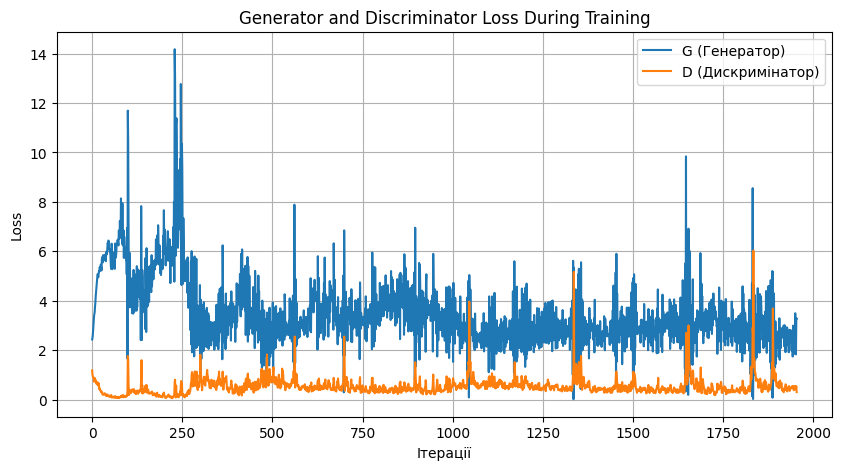

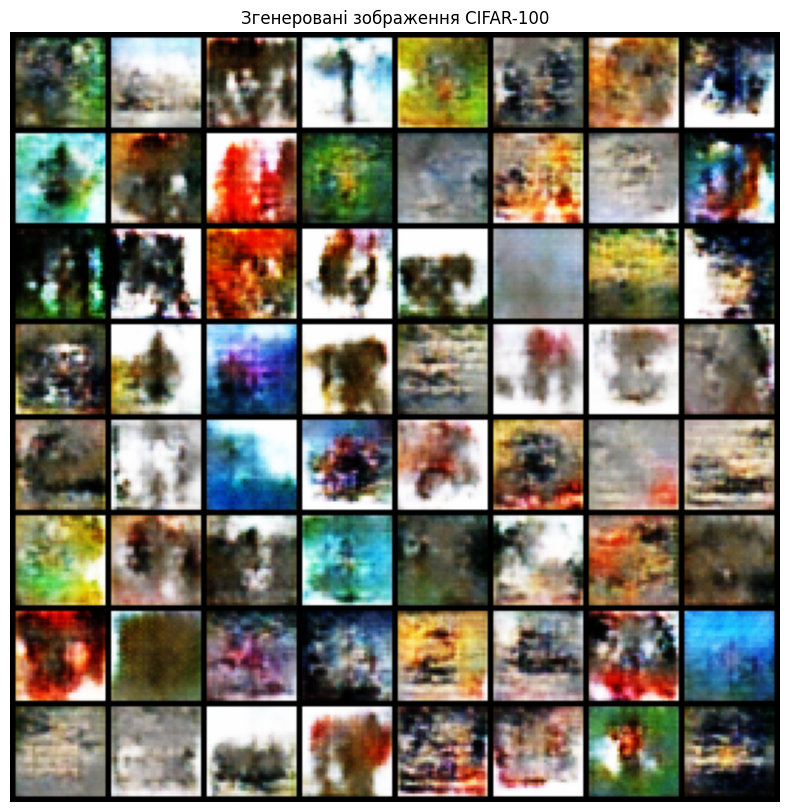

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# 1. Побудова графіка Loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G (Генератор)")
plt.plot(D_losses, label="D (Дискримінатор)")
plt.xlabel("Ітерації")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# 2. Візуалізація згенерованих зображень
if len(img_list) > 0:
    plt.figure(figsize=(10,10))
    plt.axis("off")
    plt.title("Згенеровані зображення CIFAR-100")
    # Беремо останню збережену сітку зображень
    final_grid = np.transpose(img_list[-1], (1, 2, 0))
    plt.imshow(final_grid)
    plt.show()
else:
    print("Список зображень порожній. Перевірте, чи пройшла хоча б одна епоха навчання.")

3. Проведіть експерименти з моделями бібліотеки Hugging Face (https://huggingface.co/) (2 завдання з 3х на ваш вибір)

b) Знайдіть українські мовні моделі, наведіть приклади роботи з ними (через pipeline) на завданнях
 (zero-shot-classification, summarization, translation).

In [8]:
!pip install transformers sentencepiece sacremoses PyPDF2 python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 22.7 MB/s eta 0:00:00


In [9]:
import os
import zipfile
import re
from google.colab import files
from transformers import pipeline
import PyPDF2
from docx import Document

# 1. Завантаження файлу
print("Крок 1: Завантажте ваш файл або архів (PDF, DOCX, TXT)")
uploaded = files.upload()

if not uploaded:
    print("Файл не було обрано.")
else:
    file_name = list(uploaded.keys())[0]

    # Створюємо папку для розпакування, якщо це архів
    if file_name.endswith('.zip'):
        with zipfile.ZipFile(file_name, 'r') as zip_ref:
            zip_ref.extractall("extracted_files")
        print("Архів розпаковано.")
        extracted = [f for f in os.listdir("extracted_files") if not f.startswith('__')]
        working_file = os.path.join("extracted_files", extracted[0])
    else:
        working_file = file_name

    # 2. Функція для зчитування тексту
    def get_text(path):
        if path.endswith('.pdf'):
            text = ""
            with open(path, "rb") as f:
                reader = PyPDF2.PdfReader(f)
                for page in reader.pages:
                    content = page.extract_text()
                    if content: text += content
            return text
        elif path.endswith('.docx'):
            doc = Document(path)
            return " ".join([p.text for p in doc.paragraphs])
        else: # TXT
            with open(path, "r", encoding="utf-8") as f:
                return f.read()

    # Отримуємо текст
    try:
        full_text = get_text(working_file)
        # Очистка тексту від зайвих пробілів
        full_text = re.sub(r'\s+', ' ', full_text).strip()

        # Беремо невеликий шматок (до 400 символів), щоб уникнути помилки довжини
        sample_text = full_text[:400]
        print(f"\n--- ОРИГІНАЛ ({working_file}) ---\n", sample_text)

        # 3. Налаштування моделі
        print("\nЗавантаження моделі... (це може зайняти хвилину)")
        # Якщо en-ine працює некоректно, замініть на "Helsinki-NLP/opus-mt-en-uk"
        translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk")

        # 4. Переклад
        print("Виконується переклад...")
        translated = translator(sample_text)
        result_text = translated[0]['translation_text']

        print("\n--- РЕЗУЛЬТАТ ПЕРЕКЛАДУ ---\n", result_text)

    except Exception as e:
        print(f"Помилка при обробці файлу: {e}")

Крок 1: Завантажте ваш файл або архів (PDF, DOCX, TXT)


Saving Capybaras are gentle giants of the rodent world.docx to Capybaras are gentle giants of the rodent world.docx

--- ОРИГІНАЛ (Capybaras are gentle giants of the rodent world.docx) ---
 Capybaras are gentle giants of the rodent world. These semi-aquatic mammals, native to South America, are known for their calm demeanor and social nature. They love water, using their webbed feet to swim and dive to escape danger. You'll often find them relaxing in groups by rivers, munching on grasses. Their friendly faces have made them internet sensations, but in the wild, they are a common pre

Завантаження моделі... (це може зайняти хвилину)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/305M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/305M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/809k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.01M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Device set to use cpu


Виконується переклад...

--- РЕЗУЛЬТАТ ПЕРЕКЛАДУ ---
 Капібари - м'які гіганти гризунів. Ці напів- акватичні ссавці, які живуть у Південній Америці, відомі своїми тихими манерами та соціальною природою. Вони люблять воду, використовують свої перетинчасті лапи для плавання і пірнання, щоб уникнути небезпеки. Часто вони відпочивають у групах річками, б'ються травами. Їхні дружні обличчя зробили їх інтернет сенсацією, але у дикій природі вони є звичайними передвісниками на небезпеку.


In [11]:
from transformers import pipeline

# 1. Використовуємо вказану вами модель
model_name = "MoritzLaurer/mDeBERTa-v3-base-xnli-multilingual-nli-2mil7"
classifier = pipeline("zero-shot-classification", model=model_name)

# 2. Перевірка наявності перекладеного тексту
# result_text — це змінна з попереднього блоку (результат перекладу)
if 'result_text' in locals():
    text_to_analyze = result_text
    print("Текст для аналізу взято з результатів перекладу.")
else:
    # Запасний варіант, якщо ви запустили цей блок окремо
    text_to_analyze = "Українська мова — це скарб нашого народу."
    print("Увага: Змінну з перекладом не знайдено, використано тестовий текст.")

# 3. Категорії для класифікації
candidate_labels = ["література", "технології", "наука", "освіта", "мистецтво"]

# 4. Процес класифікації
print(f"Аналізуємо перекладений текст: {text_to_analyze[:100]}...")
result = classifier(text_to_analyze, candidate_labels=candidate_labels)

# 5. Вивід результатів
print("\nРезультати класифікації:")
for label, score in zip(result['labels'], result['scores']):
    print(f"- {label}: {score:.4f}")

# 6. Висновок для звіту
top_label = result['labels'][0]
top_score = result['scores'][0]
print(f"\nВисновок: Після перекладу модель класифікувала текст як '{top_label}' ({top_score:.2%}).")
print("Це підтверджує, що переклад зберіг основний контекст оригіналу.")

Device set to use cpu


Текст для аналізу взято з результатів перекладу.
Аналізуємо перекладений текст: Капібари - м'які гіганти гризунів. Ці напів- акватичні ссавці, які живуть у Південній Америці, відом...

Результати класифікації:
- література: 0.5547
- освіта: 0.2306
- наука: 0.1363
- технології: 0.0444
- мистецтво: 0.0339

Висновок: Після перекладу модель класифікувала текст як 'література' (55.47%).
Це підтверджує, що переклад зберіг основний контекст оригіналу.


In [13]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

# 1. Налаштування моделі
# XLSum — одна з найкращих мультимовних моделей для стиснення новин та статей
model_name = "csebuetnlp/mT5_multilingual_XLSum"
print(f"Завантаження моделі {model_name}... (це може зайняти час)")

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

# Створюємо пайплайн
summarizer = pipeline(
    "summarization",
    model=model,
    tokenizer=tokenizer
)

# 2. Підготовка текстів (Оригінал та Переклад)
texts_to_process = []
if 'sample_text' in locals():
    texts_to_process.append(("ОРИГІНАЛ", sample_text))
if 'result_text' in locals():
    texts_to_process.append(("ПЕРЕКЛАД", result_text))

# 3. Виконання
if not texts_to_process:
    print("Помилка: Тексти не знайдені. Запустіть блоки з завантаженням та перекладом.")
else:
    for label, text in texts_to_process:
        print(f"\n--- ОБРОБКА: {label} ---")

        # Моделі T5 краще працюють, якщо текст очищений
        clean_text = text.replace("\n", " ").strip()

        # Генеруємо резюме
        # XLSum зазвичай видає результат коротко, тому max_length 50-60 цілком достатньо
        summary_result = summarizer(
            clean_text,
            max_length=60,
            min_length=15,
            do_sample=False
        )

        summary_text = summary_result[0]['summary_text']

        print(f"Вхідний текст ({label}): {text[:120]}...")
        print(f"РЕЗЮМЕ ({label}): {summary_text}")

Завантаження моделі csebuetnlp/mT5_multilingual_XLSum... (це може зайняти час)


tokenizer_config.json:   0%|          | 0.00/375 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/730 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

Device set to use cpu



--- ОБРОБКА: ОРИГІНАЛ ---
Вхідний текст (ОРИГІНАЛ): Capybaras are gentle giants of the rodent world. These semi-aquatic mammals, native to South America, are known for thei...
РЕЗЮМЕ (ОРИГІНАЛ): They're known as capybaras, but in the wild, they've become a popular sight.

--- ОБРОБКА: ПЕРЕКЛАД ---
Вхідний текст (ПЕРЕКЛАД): Капібари - м'які гіганти гризунів. Ці напів- акватичні ссавці, які живуть у Південній Америці, відомі своїми тихими мане...
РЕЗЮМЕ (ПЕРЕКЛАД): Капібари - дикі ссавці, які живуть у Південній Америці.
